## Preprocessing XRAY
#### - All images are dicom
#### - Original images shape 1024 x 1024
#### - Resize images to 224 x 224
#### - Split train set to 24000 train and 2684 valid images
#### - Standardize the pixel values into interval [0, 1] by scaling 1/255
#### - Classes 0 if no pneumonia - stored in directory 0
#### - Classes 1 if pneumonia - - stored in directory 1

## Normalization

#### Compute training mean and std for normalization
#### Dataset does not fit to memory -> Use a trick to compute the mean and std dev
#### Compute $\sum x$ and $\sum x^2$ for each image X and add to variables sums and sums_squared
### $\mu = \frac{sums}{N}$
### $\sigma = \sqrt\frac{\text{sums_squared}}{N} - \mu^2$
###  Z- normalize $x_{norm} = \frac{x - \mu}{\sigma}$
### Apply data augmentation:
#### - Random Rotations
#### - Random Translations
#### - Random Scales
#### - Random Resized Crops

## Class Activation Map
#### Extract output A(features) with k filters of the last convolution layer
#### Extract weights w of the fully conncected layer
#### Compute the dot product between A and w
### $M = \sum_{k }w_kA_k$

### Pre processing

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# root: /ocean/projects/asc170022p/shg121/POC/Med-AI-Course
labels = pd.read_csv("./data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
# row 4 and 5 correspond to same image. For classification we need to remove duplicates
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [3]:
labels = labels.drop_duplicates("patientId")
ROOT_PATH = Path("./data/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("./data/rsna-pneumonia-detection-challenge/Processed")

data/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm
data/rsna-pneumonia-detection-challenge/stage_2_train_images/008c19e8-a820-403a-930a-bc74a4053664.dcm


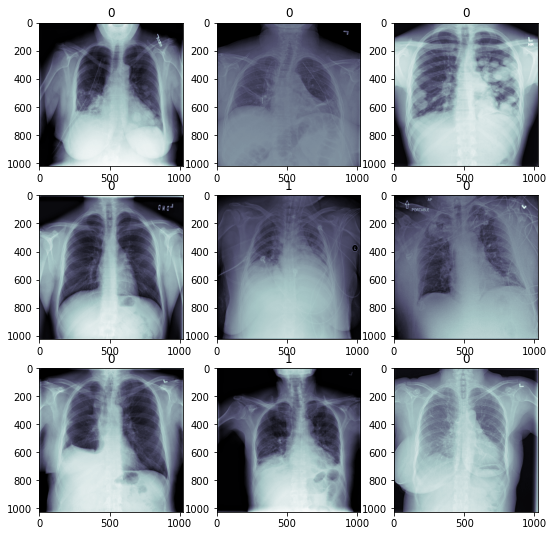

In [4]:
# visualize
fig, axis = plt.subplots(3, 3, figsize = (9,9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        # appending paths to path object
        dcm_path = ROOT_PATH/patient_id
        # For dicom images we need to add extensions
        dcm_path = dcm_path.with_suffix(".dcm")
        print(dcm_path)
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

In [30]:
# Pre Process and store them in the corresponding folders based on label 0 or 1
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    # standardization 
    dcm = pydicom.read_file(dcm_path).pixel_array/255
    
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    label = labels.Target.iloc[c]
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    # normalizer
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array)/normalizer
        sums_squared +=(dcm_array ** 2).sum() / normalizer 
        

  0%|          | 0/26684 [00:00<?, ?it/s]

In [31]:
mean = sums / 24000
std = np.sqrt((sums_squared/24000) - mean ** 2)

mean , std

(0.4903962485384803, 0.24795070634161256)

# Create datasets

In [6]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(
        degrees=(-5,5), 
        translate=(0,0.05), 
        scale=(0.9, 1.1)
    ),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)) # Atleast 35% of image so that the 
                                                              # portion with peneumonia won't 
                                                              # dissapear due to cropping
])


val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
])


In [5]:
train_dataset = torchvision.datasets.DatasetFolder(
    "./data/rsna-pneumonia-detection-challenge/Processed/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms
)
val_dataset = torchvision.datasets.DatasetFolder(
    "./data/rsna-pneumonia-detection-challenge/Processed/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms
)

1433
torch.Size([1, 224, 224])
3200
torch.Size([1, 224, 224])
3821
torch.Size([1, 224, 224])
8096
torch.Size([1, 224, 224])


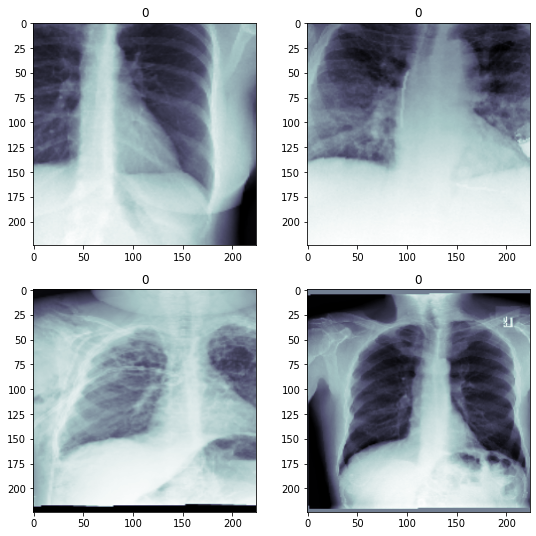

In [8]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        rand_indx = np.random.randint(0, 24000)
        print(rand_indx)
        xray, label = train_dataset[rand_indx]
        print(xray.size())
        axis[i][j].imshow(xray[0], cmap="bone")
        axis[i][j].set_title(label)

In [7]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

In [45]:
# 0-class has more data
# To mitigate this we will use weighted loss of 3 as 18593 = 3 x 5407
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

### Train

In [56]:
# torchvision.models.resnet18()

In [9]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1, 
            out_channels=64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False
        )
        self.model.fc = torch.nn.Linear(
            in_features=512, 
            out_features=1, 
            bias=True
        )
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        # 0-class has more data
        # To mitigate this we will use weighted loss of 3 as 18593 = 3 x 5407
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        xray, label = batch
        label = label.float()
        
        # print(xray.size())
        # torch.Size([64, 1, 224, 224])
        
        # print(label.size())
        # torch.Size([64])
        
        # call forward method using this
        pred = self(xray)
        # print(pred.size())
        # torch.Size([64, 1])
        # print(pred[0])
        # tensor([-2.8019], device='cuda:0')
        
        pred = pred[:, 0]
        # print(pred.size())
        # torch.Size([64])
        # Compute loss
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        # Calculate the training accuracy on the whole training set
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        xray, label = batch
        label = label.float()
        
        # print(xray.size())
        # torch.Size([64, 1, 224, 224])
        
        # print(label.size())
        # torch.Size([64])
        
        # call forward method using this
        pred = self(xray)
        # print(pred.size())
        # torch.Size([64, 1])
        # print(pred[0])
        # tensor([-2.8019], device='cuda:0')
        
        pred = pred[:, 0]
        # print(pred.size())
        # torch.Size([64])
        
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
    
    def validation_epoch_end(self, outs):
        # Calculate the training accuracy on the whole training set
        self.log("Val_ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        # this functions returns the list of optimizers
        return [self.optimizer]

### Trainer

In [10]:
model = PneumoniaModel()

In [121]:
# create checkpoints to store 10 best models based on the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor="Val_ACC",
    dirpath="./chkpt",
    filename="Pneumonia-{epoch:02d}-{Val_ACC:.2f}",
    save_top_k=10,
    mode ="max" # for best accuracy not worst
)

In [122]:
gpus=1
trainer = pl.Trainer(
    gpus=gpus,
    logger=TensorBoardLogger(save_dir="./logs"), 
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=35
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [123]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Evaluation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PneumoniaModel.load_from_checkpoint("./chkpt/Pneumonia-epoch=34-Val_ACC=0.78.ckpt")
model.eval()
model.to(device)


FileNotFoundError: [Errno 2] No such file or directory: '/ocean/projects/asc170022p/shg121/POC/Med-AI-Course/./chkpt/Pneumonia-epoch=34-Val_ACC=0.78.ckpt'

In [134]:
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int() # torchmetrics always want labels to be int
    

  0%|          | 0/2684 [00:00<?, ?it/s]

In [135]:
preds

tensor([0.1647, 0.0019, 0.0027,  ..., 0.9252, 0.8250, 0.8962])

In [136]:
labels

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)

In [137]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}") # low precision means many images without actual 
                                     # Pneumonia are predicted to be Penumonic 
print(f"Val Recall: {recall}") # High recall tells us model rarely misses Pneunomia
print("Confusion Matrix")
print(cm)

Val Accuracy: 0.7615499496459961
Val Precision: 0.4836905896663666
Val Recall: 0.8578512668609619
Confusion Matrix
tensor([[1525.,  554.],
        [  86.,  519.]])


## CAM - Interpretability

In [78]:
%matplotlib notebook

In [139]:
val_dataset

Dataset DatasetFolder
    Number of datapoints: 2684
    Root location: ./data/rsna-pneumonia-detection-challenge/Processed/val/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.248)
           )

In [140]:
# Extract the last conv layer of Resnet18 - layer 4, BasicBlock, 2nd Conv
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [141]:
temp_model.children()

<generator object Module.children at 0x14aeded09580>

In [142]:
list(temp_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [144]:
# remove AdaptiveAvgPool2d and last Linear layer
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [145]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [58]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1, 
            out_channels=64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False
        )
        self.model.fc = torch.nn.Linear(
            in_features=512, 
            out_features=1
        )
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        feature_maps = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(
            input=feature_maps,
            output_size=(1, 1)
        )
        avg_output_flatten = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flatten)
        return pred, feature_maps

In [59]:
model = PneumoniaModel.load_from_checkpoint(
    "./chkpt/Pneumonia-epoch=34-Val_ACC=0.78.ckpt",
    strict=False # for adding feature_map as during training feature_map was not computed
)
model.eval();

/ocean/projects/asc170022p/shg121/anaconda3/envs/pytorch_med_AI/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:205: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map

In [73]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
        print(f"feature_map size: {features.size()}")
    features = features.reshape((512, 49))
    print(f"feature_map reshaped size: {features.size()}")
    weights_param = list(model.model.fc.parameters())[0]
    print(len(weights_param))
    weight = weights_param[0].detach()
    print(f"weight_size: {weight.size()}")
    cam = torch.matmul(weight, features)
    print(f"cam_size: {cam.size()}")
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [74]:
def visualize(img, cam, pred):
    img = img[0]
    # resize 7x7 class activation map for original size of the image 224x224
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title("Pneumonia = 1" if pred > 0.5 else "Pneumonia = 0")

In [75]:
img, label = val_dataset[-6]
activation_map, pred = cam(model, img)

feature_map size: torch.Size([1, 512, 7, 7])
feature_map reshaped size: torch.Size([512, 49])
1
weight_size: torch.Size([512])
cam_size: torch.Size([49])


<IPython.core.display.Javascript object>


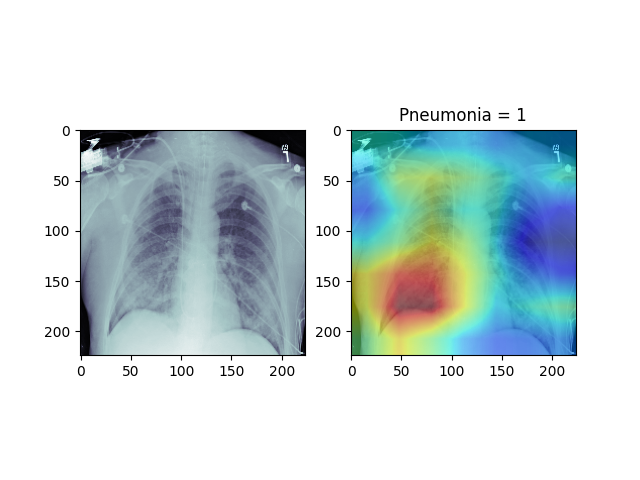

In [79]:
visualize(img, activation_map, pred)

In [ ]:
import torchmetrics

root = "/ocean/projects/asc170022p/shg121/PhD/LENS_ChestXRay/output/classifier/Dense_Net/Stanford_ChestXRay_256_channel_3_2021_11_07/predictions"
y_pred = "2021_12_10_best_epoch_3_time_2021_11_07_02_01_18_out_put_predict_test_np_normalize.npy"
y_GT = "2021_12_10_best_epoch_3_time_2021_11_07_02_01_18_out_put_GT_test_np_normalize.npy"

y_pred = np.load(os.path.join(root, y_pred))
y_GT = np.load(os.path.join(root, y_GT))

print(y_pred.shape)
print(y_GT.shape)

y_pred_0 = torch.tensor(y_pred[:, 0])
y_GT_0 = torch.tensor(y_GT[:, 0])

print(y_pred_0)
print(y_GT_0)


recall = torchmetrics.Recall()(preds, labels)